In [ ]:
import pickle
dataList = []
path = '/data/'
with open(path + 'dataList_c1.pkl', 'rb') as dataFile:
    dataList.append(pickle.load(dataFile))
with open(path + 'dataList_c4.pkl', 'rb') as dataFile:
    dataList.append(pickle.load(dataFile))
with open(path + 'dataList_c6.pkl', 'rb') as dataFile:
    dataList.append(pickle.load(dataFile))


In [ ]:
wearData = []
with open(path + 'wear_c1.pkl', 'rb') as dataFile:
    wearData.append(pickle.load(dataFile))
with open(path + 'wear_c4.pkl', 'rb') as dataFile:
    wearData.append(pickle.load(dataFile))
with open(path + 'wear_c6.pkl', 'rb') as dataFile:
    wearData.append(pickle.load(dataFile))

In [3]:
import numpy as np
# dimension add the first wear value
dataList = np.asarray(dataList)
wearData = np.asarray(wearData)
wearData = wearData.reshape(3,315,1)
tmp = dataList[:,1]
tmp = np.tile(tmp,315).reshape(3,315,-1)
dataList = np.concatenate([dataList,tmp],axis = 2)
dim = dataList.shape[2]


In [4]:
print(dataList.shape)
print(wearData.shape)

(3, 315, 1302)
(3, 315, 1)


In [5]:
# choose train data and test data
trainDataX = np.asarray([dataList[1],dataList[2]])
trainDataY = np.asarray([wearData[1],wearData[2]])
testDataX = np.asarray(dataList[0])
testDataY = np.asarray(wearData[0])

In [6]:
# normalization 
trainDataX = trainDataX.reshape(-1,dim)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(trainDataX)
trainStdX = scaler.transform(trainDataX)
testStdX = scaler.transform(testDataX)
trainStdX = trainStdX.reshape(-1,315,dim)

In [7]:
def create_dataset(inputData, outputData, look_back):
    dataX = []
    dataY = []
    for i in range(len(inputData)-look_back-1):
        x = inputData[i:(i+look_back), :]
        y = outputData[i,:]
        dataX.append(x)
        dataY.append(y)
    return np.array(dataX), np.array(dataY)

In [8]:
look_back = 1
dataSetX = []
dataSetY = []

for i in range(2):
    x, y = create_dataset(trainStdX[i], trainDataY[i], look_back)
    dataSetX.append(x)
    dataSetY.append(y)
testX, testY = create_dataset(testStdX, testDataY, look_back)

In [9]:
print(np.asarray(dataSetX).shape)
print(np.asarray(dataSetY).shape)
print(np.asarray(testX).shape) 
print(np.asarray(testY).shape)

(2, 313, 1, 1302)
(2, 313, 1)
(313, 1, 1302)
(313, 1)


In [10]:
def get_batch(inputData,outputData,batchSize):
    batchX = []
    batchY = []
    for i in range(int(inputData.shape[0] / batchSize)):
        x = inputData[i*batchSize : i*batchSize + batchSize,:]
        y = outputData[i*batchSize : i*batchSize + batchSize,:]
        batchX.append(x)
        batchY.append(y)
    return np.array(batchX), np.array(batchY)

In [11]:
batch_size = 1
batch_X = []
batch_Y = []
for i in range(2):
    x, y = get_batch(dataSetX[i], dataSetY[i], batch_size)
    batch_X.append(x)
    batch_Y.append(y)
batch_X =np.asarray(batch_X)
batch_Y = np.asarray(batch_Y)
print(batch_X.shape)
print(batch_Y.shape)   

(2, 313, 1, 1, 1302)
(2, 313, 1, 1)


In [12]:
trainX = batch_X
trainY = batch_Y

In [13]:
trainX = np.asarray(trainX)
trainY = np.asarray(trainY)
print(trainX.shape)
print(trainY.shape)
print(np.asarray(testX).shape)
print(np.asarray(testY).shape)
train_len = len(trainX[1])
test_len = len(testX)

(2, 313, 1, 1, 1302)
(2, 313, 1, 1)
(313, 1, 1302)
(313, 1)


In [14]:
print(trainX[:,1].shape)

(2, 1, 1, 1302)


In [ ]:
# Global config variables
learning_rate = 0.0001
training_epochs = 2000

In [16]:
input_dim = dim + 1 # add 1 because need the last prediction wear
fuzzy_size = 3
fuzzy_dim = (input_dim) * fuzzy_size
hidden1_dim = np.power(2,int(np.log2(fuzzy_dim))+1)
return_dim = hidden1_dim
hidden2_dim = hidden1_dim/8
hidden3_dim = hidden2_dim/8
hidden4_dim = hidden3_dim/8
output_dim = 1


In [17]:
import tensorflow as tf
X = tf.placeholder(tf.float64,[None,look_back, input_dim],name='x')
Y = tf.placeholder(tf.float64,[None, output_dim],name='y')
learning_rate_tf = tf.placeholder(tf.float64,name='rate')
init_state = tf.placeholder(tf.float64,[None,return_dim],name='state')

rnn_inputs = tf.unstack(X, axis=1)

/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [18]:
with tf.variable_scope('InputLayer_to_FuzzyLayer'):
    # input layer to fuzzy layer1
    Fw1 = tf.get_variable('weight', [fuzzy_dim, 1], dtype=tf.float64)
    Fmean = tf.get_variable('mean', [fuzzy_dim,1], dtype=tf.float64)
    Fsigma = tf.get_variable('sigma', [fuzzy_dim,1], dtype=tf.float64)
    # add summary
    tf.summary.histogram("wegiht", Fw1)
    tf.summary.histogram('mean', Fmean)
    tf.summary.histogram('sigma', Fsigma)

In [19]:
with tf.variable_scope('FuzzyLayer_to_HiddenLayer1'):
    # fuzzy layer1 to hidden layer1
    w1 = tf.get_variable('weight', [fuzzy_dim + return_dim, hidden1_dim], dtype=tf.float64)
    b1 = tf.get_variable('bias', [hidden1_dim], dtype=tf.float64)
    
    # add summary
    tf.summary.histogram('weight', w1)
    tf.summary.histogram('bias', b1)
    

In [20]:
with tf.variable_scope('HiddenLayer1_to_HiddenLayer2'):
    # hidden layer1 to hidden layer2
    w2 = tf.get_variable('weight', [hidden1_dim, hidden2_dim], dtype=tf.float64)
    b2 = tf.get_variable('bias', [hidden2_dim], dtype=tf.float64)
    
    # add summary
    tf.summary.histogram('weight', w2)
    tf.summary.histogram('bias', b2)


In [21]:
with tf.variable_scope('HiddenLayer2_to_HiddenLayer3'):
    # hidden layer2 to hidden layer3
    w3 = tf.get_variable('weight', [hidden2_dim, hidden3_dim], dtype=tf.float64)
    b3 = tf.get_variable('bias', [hidden3_dim], dtype=tf.float64)
    
    # add summary
    tf.summary.histogram('weight', w3)
    tf.summary.histogram('bias', b3)

In [22]:
with tf.variable_scope('HiddenLayer3_to_HiddenLayer4'):
    # hidden layer3 to hidden layer4
    w4 = tf.get_variable('weight', [hidden3_dim, hidden4_dim], dtype=tf.float64)
    b4 = tf.get_variable('bias', [hidden4_dim], dtype=tf.float64)
    
    # add summary
    tf.summary.histogram('weight', w4)
    tf.summary.histogram('bias', b4)
    

In [23]:
with tf.variable_scope('HiddenLayer4_to_OutputLayer'):
    # hidden layer4 to hidden layer5
    w5 = tf.get_variable('weight', [hidden4_dim, output_dim], dtype=tf.float64)
    b5 = tf.get_variable('bias', [output_dim], dtype=tf.float64)
    
    # add summary
    tf.summary.histogram('weight', w5)
    tf.summary.histogram('bias', b5)
    

In [24]:
def rnn_cell(rnn_input, state):
    with tf.variable_scope('InputLayer_to_FuzzyLayer', reuse=True):
        Fw1 = tf.get_variable('weight', dtype=tf.float64)
        Fmean = tf.get_variable('mean', dtype=tf.float64)
        Fsigma = tf.get_variable('sigma', dtype=tf.float64)
    with tf.variable_scope('FuzzyLayer_to_HiddenLayer1', reuse=True):
        w1 = tf.get_variable('weight', dtype=tf.float64)
        b1 = tf.get_variable('bias', dtype=tf.float64)
    with tf.variable_scope('HiddenLayer1_to_HiddenLayer2', reuse=True):
        w2 = tf.get_variable('weight', dtype=tf.float64)
        b2 = tf.get_variable('bias', dtype=tf.float64)
    with tf.variable_scope('HiddenLayer2_to_HiddenLayer3', reuse=True):
        w3 = tf.get_variable('weight', dtype=tf.float64)
        b3 = tf.get_variable('bias', dtype=tf.float64)
    with tf.variable_scope('HiddenLayer3_to_HiddenLayer4', reuse=True):
        w4 = tf.get_variable('weight', dtype=tf.float64)
        b4 = tf.get_variable('bias', dtype=tf.float64)
    with tf.variable_scope('HiddenLayer4_to_OutputLayer', reuse=True):
        w5 = tf.get_variable('weight', dtype=tf.float64)
        b5 = tf.get_variable('bias', dtype=tf.float64)

    rnn_input = tf.tile(rnn_input,[1,3])
    rnn_input = tf.transpose(rnn_input)
    result = tf.multiply(rnn_input,Fw1)
    result = tf.subtract(result,Fmean)
    result = tf.multiply(tf.square(result),-1)
    result = tf.divide(result,tf.square(Fsigma))
    result = tf.exp(result)
    result = tf.transpose(result)
    result = tf.nn.relu(tf.add(tf.matmul(tf.concat([result,state],1),w1),b1))
    state = result
    result = tf.add(tf.matmul(result,w2),b2)
    result = tf.add(tf.matmul(result,w3),b3)
    result = tf.add(tf.matmul(result,w4),b4)
    result = tf.add(tf.matmul(result,w5),b5)

    return result, state


In [25]:
state_list = []
y_pred_list = []
state = init_state
for rnn_input in rnn_inputs:
    y_pred,state = rnn_cell(rnn_input, state)
    y_pred_list.append(y_pred)
    state_list.append(state)
prediction = y_pred
tf.add_to_collection('prediction_fun',prediction)
final_state = state_list[0]
tf.add_to_collection('state_fun',final_state)


In [26]:
with tf.name_scope('Loss'):
    loss =  tf.losses.mean_squared_error(Y,prediction);
    tf.summary.scalar("loss",loss)
    

In [27]:
with tf.name_scope('Accuracy'):
    RMSE = tf.sqrt(tf.losses.mean_squared_error(Y,prediction))
    sub = tf.subtract(Y,prediction)
    Precision = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(sub,tf.reduce_mean(sub)))))
    tf.summary.scalar("RMSE",RMSE)
    tf.summary.scalar("Precision",Precision)

In [28]:
with tf.name_scope('Optimizer'):
    regularization_loss = tf.nn.l2_loss(Fw1) + tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2)\
    + tf.nn.l2_loss(w3) + tf.nn.l2_loss(w4) + tf.nn.l2_loss(w5)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_tf).minimize\
    (tf.reduce_mean(tf.cast(loss,tf.float64) + regularization_loss * 0.01)) 

In [ ]:
import time
for which_train_model in range(5):
    tStart = time.time()
    losses = []
    val_losses = []
    saver = tf.train.Saver()
    while(1):
        with tf.Session() as sess:
            final_RMSE = 10000000000
            for k in range(1):
                print('%d' % (which_train_model+1)," Times :")

                # init Variables
                sess.run(tf.global_variables_initializer())
                global_step = 0
                total_batch_loss = 0
                proportion = training_epochs / 10
                for epoch in range(training_epochs):
                    if epoch % proportion == 0 and epoch !=0:
                        print(epoch / proportion * 10,"%")
                        print('batch_loss',batch_loss/train_len/2)
                        print('batch_acc',batch_acc/train_len/2)
                    # add the last prediction wear , but the first time need to add the realy wear
                    for index in range(2):
                        training_state = np.zeros((batch_size, return_dim), dtype=np.float64)
                        if index == 0:
                            batch_loss = 0
                            batch_acc = 0

                        for i in range(train_len):
                            if(i == 0):
                                tmp = np.asarray([0]).reshape([1,1,1])
                                inputX = np.concatenate([trainX[index,i],tmp],axis = 2)
                            else:
                                step_pre = np.stack(step_pre,axis = 1)
                                inputX = np.concatenate([trainX[index,i],tmp],axis = 2)
                            step_pre = sess.run(y_pred_list, feed_dict={X: inputX, Y: trainY[index,i], init_state: training_state,learning_rate_tf: learning_rate})
                            if np.isnan(step_pre) == 1:
                                flag = 1
                                break
                            else:
                                flag = 0
                            training_state = sess.run(final_state, feed_dict={X: inputX, Y: trainY[index,i], init_state: training_state,learning_rate_tf: learning_rate})
                            sess.run(optimizer, feed_dict={X: inputX, Y: trainY[index,i], init_state: training_state,learning_rate_tf: learning_rate})
                            batch_loss = batch_loss + sess.run(loss,\
                                                               feed_dict={X: inputX, Y: trainY[index,i], init_state: training_state,learning_rate_tf: learning_rate})
                            batch_acc = batch_acc + sess.run(RMSE,\
                                                             feed_dict={X: inputX, Y: trainY[index,i], init_state: training_state,learning_rate_tf: learning_rate})
                            global_step += 1
                    if flag == 1 :
                        break
                print("100%")
                print('batch_loss',batch_loss/train_len/2)
                print('batch_acc',batch_acc/train_len/2)

                pre = np.asarray([])
                test_state = np.zeros((1,return_dim), dtype=np.float64)
                for i in range(test_len):
                    if(i == 0):
                        tmp = np.asarray([0]).reshape([1,1,1])
                        inputX = np.concatenate([testX[index,i].reshape([1,look_back,dim]),tmp],axis = 2)
                    else:
                        step_pre = np.stack(step_pre,axis = 1)
                        inputX = testX[i].reshape([1,look_back,dim])
                        inputX = np.concatenate([inputX,step_pre],axis = 2)

                    step_pre = sess.run(y_pred_list, feed_dict={X: inputX, Y: testY[i].reshape([1,1]), init_state: test_state,learning_rate_tf: learning_rate})
                    result = sess.run(prediction, feed_dict=\
                               {X:inputX, Y:testY[i].reshape([1,1]), init_state: test_state,learning_rate_tf: learning_rate})
                    test_state = sess.run(final_state, feed_dict=\
                                          {X: inputX, Y: testY[i].reshape([1,1]), init_state: test_state,learning_rate_tf: learning_rate})
                    pre = np.append(pre,result)

                test_RMSE = np.sqrt(np.square(np.subtract(testY.reshape([-1]), pre)).mean())
                sub = np.subtract(testY.reshape([-1]),pre)
                test_Precision = np.sqrt(np.mean(np.square(np.subtract(sub,np.mean(sub)))))
                test_NRMSE = test_RMSE / np.subtract(testY.reshape([-1]), pre).mean()
                test_RULA = (1 - np.mean(np.absolute((testY[1:].reshape(-1) - pre[1:]) / testY[1:].reshape(-1)))) * 100
                if final_RMSE > test_RMSE:
                    final_RMSE = test_RMSE
                    final_Precision = test_Precision
                    final_NRMSE = test_NRMSE
                    final_pre = pre
                    saver.save(sess, 'Fuzzy_RNN_Model_3/ChooseModel/ChooseModel_regularization_' + str(which_train_model) + '.ckpt')
        if np.isnan(test_RMSE) != 1 and flag == 0 :
            break


1  Times :
10.0 %
batch_loss 16.908781537248775
batch_acc 2.8630732240768286
20.0 %
batch_loss 14.9014702255769
batch_acc 2.9953693231454674
30.0 %
batch_loss 4.224904029470286
batch_acc 1.574345664856152
40.0 %
batch_loss 3.6983543458250026
batch_acc 1.4142729878044737
50.0 %
batch_loss 7.392582949186685
batch_acc 2.1874950396748014
60.0 %
batch_loss 7.449862373770849
batch_acc 2.185074900666746
70.0 %
batch_loss 7.205973797735532
batch_acc 1.866674612124507
80.0 %
batch_loss 10.999752271880274
batch_acc 2.466122532804934
90.0 %
batch_loss 8.64710302841963
batch_acc 2.306828337355544
100%
batch_loss 5.365033721016644
batch_acc 1.885442087825495
2  Times :
10.0 %
batch_loss 19.695375675668778
batch_acc 3.3474808775197964
20.0 %
batch_loss 8.860167379241208
batch_acc 2.2938466818568806
30.0 %
batch_loss 15.514460973467358
batch_acc 2.9659827844784283
40.0 %
batch_loss 17.27642717492756
batch_acc 3.1185524516974015
50.0 %
batch_loss 8.009624083075835
batch_acc 2.1563630302112324
60.0 %
b

TIME 51094.34077119827
RMSE 32.348814433834555
Precision 13.646855207655312
NRMSE 1.102951314734316


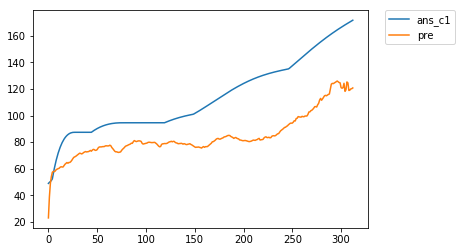

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
tEnd = time.time()
print('TIME',tEnd - tStart)
print('RMSE', final_RMSE)
print('Precision', final_Precision)
print('NRMSE', final_NRMSE)
plt.plot(testY,label='ans_c1')
plt.plot(final_pre,label='pre')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, "Fuzzy_RNN_Model_3/ChooseModel/ChooseModel_regularization.ckpt")
    
    pre = np.asarray([])
    test_state = np.zeros((1,return_dim), dtype=np.float64)
    for i in range(test_len):
        if(i == 0):
            tmp = np.asarray([0]).reshape([1,1,1])
            inputX = np.concatenate([testX[i].reshape(1,1,-1),tmp],axis = 2)
        else:
            step_pre = np.stack(step_pre,axis = 1)
            inputX = testX[i].reshape(1,1,-1)
            inputX = np.concatenate([inputX,step_pre],axis = 2)


        step_pre = sess.run(y_pred_list, feed_dict={X: inputX, Y: testY[i].reshape([1,1]), init_state: test_state,learning_rate_tf: learning_rate})
        result = sess.run(prediction, feed_dict=\
                   {X:inputX, Y:testY[i].reshape([1,1]), init_state: test_state,learning_rate_tf: learning_rate})
        test_state = sess.run(final_state, feed_dict=\
                              {X: inputX, Y: testY[i].reshape([1,1]), init_state: test_state,learning_rate_tf: learning_rate})
        pre = np.append(pre, result)

    test_RMSE = np.sqrt(np.square(np.subtract(testY.reshape([-1]), pre)).mean())
    sub = np.subtract(testY.reshape([-1]),pre)
    test_Precision = np.sqrt(np.mean(np.square(np.subtract(sub,np.mean(sub)))))
    test_NRMSE = test_RMSE / np.subtract(testY.reshape([-1]), pre).mean()

INFO:tensorflow:Restoring parameters from /home/louis/Documents/Python/PHM_second/Fuzzy_RNN_Model_3/ChooseModel/ChooseModel_regularization.ckpt


NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for /home/louis/Documents/Python/PHM_second/Fuzzy_RNN_Model_3/ChooseModel/ChooseModel_regularization.ckpt
	 [[Node: save_5/RestoreV2 = RestoreV2[dtypes=[DT_DOUBLE, DT_DOUBLE, DT_DOUBLE, DT_DOUBLE, DT_DOUBLE, ..., DT_DOUBLE, DT_DOUBLE, DT_DOUBLE, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_5/Const_0_0, save_5/RestoreV2/tensor_names, save_5/RestoreV2/shape_and_slices)]]
	 [[Node: save_5/RestoreV2/_53 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_58_save_5/RestoreV2", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op 'save_5/RestoreV2', defined at:
  File "/usr/local/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/anaconda3/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/usr/local/anaconda3/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/usr/local/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 759, in _run_callback
    ret = callback()
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/usr/local/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-32-e8a72f135817>", line 1, in <module>
    saver = tf.train.Saver()
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1293, in __init__
    self.build()
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1302, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1339, in _build
    build_save=build_save, build_restore=build_restore)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 796, in _build_internal
    restore_sequentially, reshape)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 449, in _AddRestoreOps
    restore_sequentially)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 847, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1030, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3271, in create_op
    op_def=op_def)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

NotFoundError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to find any matching files for /home/louis/Documents/Python/PHM_second/Fuzzy_RNN_Model_3/ChooseModel/ChooseModel_regularization.ckpt
	 [[Node: save_5/RestoreV2 = RestoreV2[dtypes=[DT_DOUBLE, DT_DOUBLE, DT_DOUBLE, DT_DOUBLE, DT_DOUBLE, ..., DT_DOUBLE, DT_DOUBLE, DT_DOUBLE, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_5/Const_0_0, save_5/RestoreV2/tensor_names, save_5/RestoreV2/shape_and_slices)]]
	 [[Node: save_5/RestoreV2/_53 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_58_save_5/RestoreV2", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
print('RMSE', test_RMSE)
print('Precision', test_Precision)
print('NRMSE', test_NRMSE)
plt.plot(testY,label='ans_c1')
plt.plot(pre,label='pre')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# 